# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

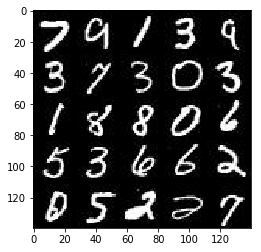

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

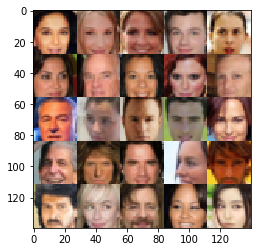

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # alpha is the param for leaky relu
        alpha = 0.2
        
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64 now
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128 now
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256 now

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        # alpha is the param for leaky relu
        alpha = 0.2
        
        # First fully connected layer
        x1 = tf.layers.dense(z, 7 * 7 * 512, activation=None)
        x1 = tf.reshape(x1, (-1, 7, 7, 512)) # Reshape it to start the convolutional stack
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 28x28x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        out = tf.tanh(logits)
        # 28x28x3 now
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    # Generator network here
    g_model = generator(input_z, out_channel_dim)

    # Disriminator network here
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    # Calculate losses
    smooth = 0.1
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real) * (1 - smooth)))

    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))

    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})

                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epoch_count), 
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                if steps % 100 == 0:
                    gen_samples = sess.run(generator(input_z, image_channels, is_train=False), feed_dict={input_z: batch_z})
                    _ = show_generator_output(sess, 25, input_z, image_channels, data_image_mode)

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

Epoch 1/2... Discriminator Loss: 0.4204... Generator Loss: 3.1223
Epoch 1/2... Discriminator Loss: 0.4827... Generator Loss: 2.2592
Epoch 1/2... Discriminator Loss: 0.4310... Generator Loss: 4.2485
Epoch 1/2... Discriminator Loss: 1.2898... Generator Loss: 2.9953
Epoch 1/2... Discriminator Loss: 1.3641... Generator Loss: 1.3200
Epoch 1/2... Discriminator Loss: 1.3577... Generator Loss: 0.6340
Epoch 1/2... Discriminator Loss: 1.5244... Generator Loss: 0.5115
Epoch 1/2... Discriminator Loss: 1.2379... Generator Loss: 0.8513
Epoch 1/2... Discriminator Loss: 1.3270... Generator Loss: 0.8379
Epoch 1/2... Discriminator Loss: 1.6648... Generator Loss: 0.4169


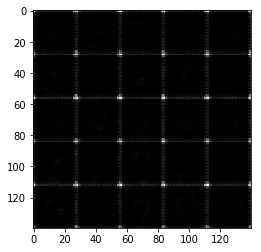

Epoch 1/2... Discriminator Loss: 1.2459... Generator Loss: 0.9999
Epoch 1/2... Discriminator Loss: 1.4056... Generator Loss: 1.7060
Epoch 1/2... Discriminator Loss: 1.3388... Generator Loss: 0.7322
Epoch 1/2... Discriminator Loss: 1.1195... Generator Loss: 1.1036
Epoch 1/2... Discriminator Loss: 1.1910... Generator Loss: 0.7477
Epoch 1/2... Discriminator Loss: 1.2023... Generator Loss: 1.2572
Epoch 1/2... Discriminator Loss: 1.2410... Generator Loss: 1.6392
Epoch 1/2... Discriminator Loss: 1.2184... Generator Loss: 0.7372
Epoch 1/2... Discriminator Loss: 1.2382... Generator Loss: 0.6883
Epoch 1/2... Discriminator Loss: 1.3832... Generator Loss: 0.4813


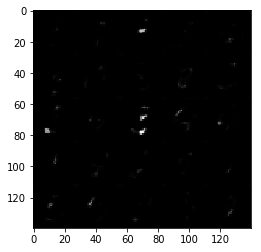

Epoch 1/2... Discriminator Loss: 1.0094... Generator Loss: 0.9240
Epoch 1/2... Discriminator Loss: 1.1167... Generator Loss: 1.6473
Epoch 1/2... Discriminator Loss: 1.4142... Generator Loss: 0.5206
Epoch 1/2... Discriminator Loss: 0.9967... Generator Loss: 1.5393
Epoch 1/2... Discriminator Loss: 1.3248... Generator Loss: 0.5312
Epoch 1/2... Discriminator Loss: 1.0156... Generator Loss: 1.1135
Epoch 1/2... Discriminator Loss: 0.9628... Generator Loss: 1.9009
Epoch 1/2... Discriminator Loss: 1.0585... Generator Loss: 1.5717
Epoch 1/2... Discriminator Loss: 1.0929... Generator Loss: 0.7814
Epoch 1/2... Discriminator Loss: 1.0840... Generator Loss: 1.0624


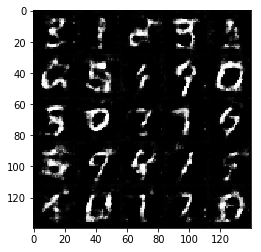

Epoch 1/2... Discriminator Loss: 1.0431... Generator Loss: 1.1230
Epoch 1/2... Discriminator Loss: 1.0236... Generator Loss: 1.0033
Epoch 1/2... Discriminator Loss: 1.1009... Generator Loss: 0.8963
Epoch 1/2... Discriminator Loss: 1.0246... Generator Loss: 1.5232
Epoch 1/2... Discriminator Loss: 1.2980... Generator Loss: 0.6295
Epoch 1/2... Discriminator Loss: 1.0272... Generator Loss: 1.3369
Epoch 1/2... Discriminator Loss: 1.1724... Generator Loss: 0.7514
Epoch 1/2... Discriminator Loss: 1.0532... Generator Loss: 1.2344
Epoch 1/2... Discriminator Loss: 1.1428... Generator Loss: 0.8638
Epoch 1/2... Discriminator Loss: 1.1750... Generator Loss: 1.1432


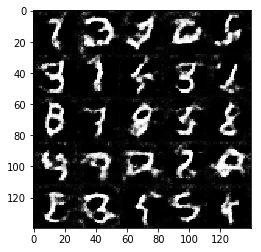

Epoch 1/2... Discriminator Loss: 1.2411... Generator Loss: 1.8333
Epoch 1/2... Discriminator Loss: 1.0503... Generator Loss: 1.0242
Epoch 1/2... Discriminator Loss: 1.1395... Generator Loss: 1.0762
Epoch 1/2... Discriminator Loss: 1.3215... Generator Loss: 0.5722
Epoch 1/2... Discriminator Loss: 1.1445... Generator Loss: 0.7874
Epoch 1/2... Discriminator Loss: 1.2529... Generator Loss: 0.6156
Epoch 1/2... Discriminator Loss: 1.0842... Generator Loss: 0.9782
Epoch 1/2... Discriminator Loss: 1.1459... Generator Loss: 0.7799
Epoch 1/2... Discriminator Loss: 1.1442... Generator Loss: 1.4652
Epoch 1/2... Discriminator Loss: 1.0300... Generator Loss: 1.2469


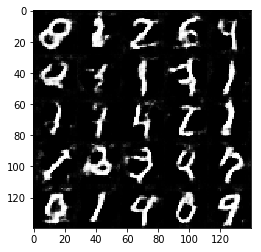

Epoch 1/2... Discriminator Loss: 1.2653... Generator Loss: 0.6031
Epoch 1/2... Discriminator Loss: 1.0865... Generator Loss: 1.2273
Epoch 1/2... Discriminator Loss: 1.2002... Generator Loss: 0.6592
Epoch 1/2... Discriminator Loss: 1.2886... Generator Loss: 0.6356
Epoch 1/2... Discriminator Loss: 1.4369... Generator Loss: 0.4941
Epoch 1/2... Discriminator Loss: 1.1444... Generator Loss: 0.9019
Epoch 1/2... Discriminator Loss: 1.1936... Generator Loss: 0.6823
Epoch 1/2... Discriminator Loss: 1.1784... Generator Loss: 1.4153
Epoch 1/2... Discriminator Loss: 1.5582... Generator Loss: 0.4257
Epoch 1/2... Discriminator Loss: 1.0860... Generator Loss: 1.3010


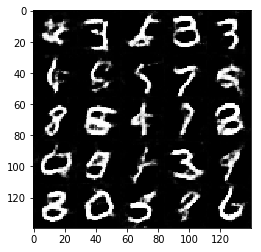

Epoch 1/2... Discriminator Loss: 1.0424... Generator Loss: 1.1105
Epoch 1/2... Discriminator Loss: 1.0549... Generator Loss: 0.9376
Epoch 1/2... Discriminator Loss: 1.1714... Generator Loss: 1.1036
Epoch 1/2... Discriminator Loss: 1.1158... Generator Loss: 1.0531
Epoch 1/2... Discriminator Loss: 1.0498... Generator Loss: 0.9878
Epoch 1/2... Discriminator Loss: 1.2111... Generator Loss: 0.8901
Epoch 1/2... Discriminator Loss: 1.4104... Generator Loss: 0.4942
Epoch 1/2... Discriminator Loss: 1.0527... Generator Loss: 1.3645
Epoch 1/2... Discriminator Loss: 1.0832... Generator Loss: 0.8888
Epoch 1/2... Discriminator Loss: 1.1123... Generator Loss: 0.8392


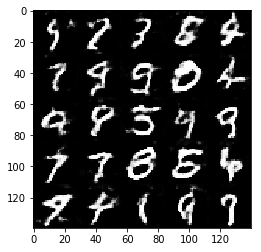

Epoch 1/2... Discriminator Loss: 0.9938... Generator Loss: 1.1336
Epoch 1/2... Discriminator Loss: 1.2817... Generator Loss: 1.7325
Epoch 1/2... Discriminator Loss: 1.0349... Generator Loss: 0.8968
Epoch 1/2... Discriminator Loss: 1.0611... Generator Loss: 1.3221
Epoch 1/2... Discriminator Loss: 1.0041... Generator Loss: 1.2203
Epoch 1/2... Discriminator Loss: 1.0210... Generator Loss: 1.1737
Epoch 1/2... Discriminator Loss: 1.0761... Generator Loss: 1.2211
Epoch 1/2... Discriminator Loss: 0.9741... Generator Loss: 1.1375
Epoch 1/2... Discriminator Loss: 1.0377... Generator Loss: 0.8915
Epoch 1/2... Discriminator Loss: 1.0852... Generator Loss: 0.9029


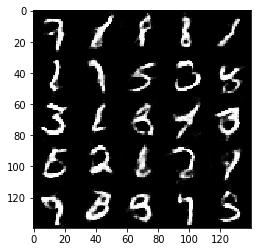

Epoch 1/2... Discriminator Loss: 1.3093... Generator Loss: 2.5877
Epoch 1/2... Discriminator Loss: 0.9853... Generator Loss: 1.1730
Epoch 1/2... Discriminator Loss: 1.0564... Generator Loss: 0.8760
Epoch 1/2... Discriminator Loss: 1.0396... Generator Loss: 1.4255
Epoch 1/2... Discriminator Loss: 1.0599... Generator Loss: 0.9275
Epoch 1/2... Discriminator Loss: 0.9641... Generator Loss: 1.3584
Epoch 1/2... Discriminator Loss: 1.1231... Generator Loss: 0.8175
Epoch 1/2... Discriminator Loss: 1.0010... Generator Loss: 1.1018
Epoch 1/2... Discriminator Loss: 1.3737... Generator Loss: 0.5330
Epoch 1/2... Discriminator Loss: 1.0614... Generator Loss: 0.9055


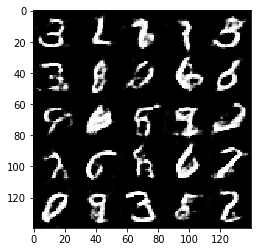

Epoch 1/2... Discriminator Loss: 1.0209... Generator Loss: 1.0810
Epoch 1/2... Discriminator Loss: 0.9956... Generator Loss: 0.9358
Epoch 1/2... Discriminator Loss: 1.2294... Generator Loss: 0.6367
Epoch 2/2... Discriminator Loss: 1.0491... Generator Loss: 0.8156
Epoch 2/2... Discriminator Loss: 1.9660... Generator Loss: 0.3475
Epoch 2/2... Discriminator Loss: 1.0618... Generator Loss: 1.2255
Epoch 2/2... Discriminator Loss: 0.9658... Generator Loss: 1.0057
Epoch 2/2... Discriminator Loss: 0.8519... Generator Loss: 1.6786
Epoch 2/2... Discriminator Loss: 1.0465... Generator Loss: 0.9361
Epoch 2/2... Discriminator Loss: 1.0060... Generator Loss: 1.0238


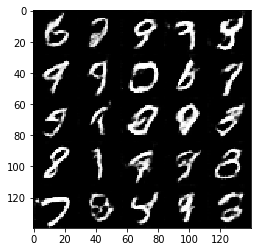

Epoch 2/2... Discriminator Loss: 1.2068... Generator Loss: 0.6641
Epoch 2/2... Discriminator Loss: 0.8739... Generator Loss: 1.2788
Epoch 2/2... Discriminator Loss: 1.2420... Generator Loss: 0.5994
Epoch 2/2... Discriminator Loss: 1.0455... Generator Loss: 1.3188
Epoch 2/2... Discriminator Loss: 1.5271... Generator Loss: 0.4801
Epoch 2/2... Discriminator Loss: 0.9442... Generator Loss: 0.9758
Epoch 2/2... Discriminator Loss: 1.1125... Generator Loss: 0.8582
Epoch 2/2... Discriminator Loss: 0.9858... Generator Loss: 0.8610
Epoch 2/2... Discriminator Loss: 1.7708... Generator Loss: 0.3445
Epoch 2/2... Discriminator Loss: 1.0218... Generator Loss: 0.9825


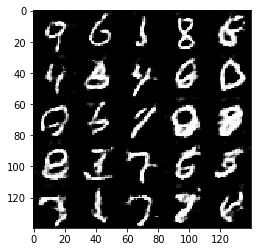

Epoch 2/2... Discriminator Loss: 0.9482... Generator Loss: 1.3030
Epoch 2/2... Discriminator Loss: 1.3452... Generator Loss: 1.9974
Epoch 2/2... Discriminator Loss: 1.0928... Generator Loss: 0.7811
Epoch 2/2... Discriminator Loss: 0.8769... Generator Loss: 1.3478
Epoch 2/2... Discriminator Loss: 1.2244... Generator Loss: 0.6451
Epoch 2/2... Discriminator Loss: 1.0969... Generator Loss: 2.4311
Epoch 2/2... Discriminator Loss: 1.0368... Generator Loss: 0.8528
Epoch 2/2... Discriminator Loss: 0.9872... Generator Loss: 1.3598
Epoch 2/2... Discriminator Loss: 1.1426... Generator Loss: 1.1906
Epoch 2/2... Discriminator Loss: 0.9564... Generator Loss: 1.2773


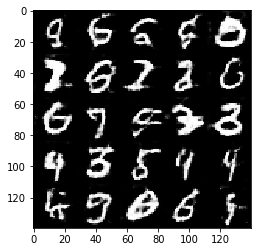

Epoch 2/2... Discriminator Loss: 0.9182... Generator Loss: 1.0495
Epoch 2/2... Discriminator Loss: 1.1554... Generator Loss: 0.6664
Epoch 2/2... Discriminator Loss: 1.0098... Generator Loss: 0.9703
Epoch 2/2... Discriminator Loss: 1.0875... Generator Loss: 0.7549
Epoch 2/2... Discriminator Loss: 0.8910... Generator Loss: 1.1223
Epoch 2/2... Discriminator Loss: 0.9773... Generator Loss: 2.6783
Epoch 2/2... Discriminator Loss: 1.0080... Generator Loss: 0.8345
Epoch 2/2... Discriminator Loss: 0.9571... Generator Loss: 1.3360
Epoch 2/2... Discriminator Loss: 0.9197... Generator Loss: 1.3654
Epoch 2/2... Discriminator Loss: 0.8306... Generator Loss: 1.2653


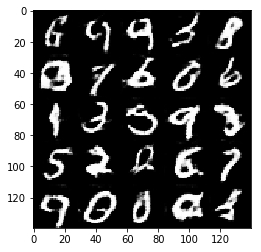

Epoch 2/2... Discriminator Loss: 0.9596... Generator Loss: 1.1294
Epoch 2/2... Discriminator Loss: 0.9953... Generator Loss: 0.8804
Epoch 2/2... Discriminator Loss: 0.9510... Generator Loss: 1.1515
Epoch 2/2... Discriminator Loss: 1.3993... Generator Loss: 2.3715
Epoch 2/2... Discriminator Loss: 0.9080... Generator Loss: 1.4359
Epoch 2/2... Discriminator Loss: 0.8572... Generator Loss: 1.2590
Epoch 2/2... Discriminator Loss: 0.8892... Generator Loss: 1.4629
Epoch 2/2... Discriminator Loss: 1.5488... Generator Loss: 2.5772
Epoch 2/2... Discriminator Loss: 0.9225... Generator Loss: 1.1753
Epoch 2/2... Discriminator Loss: 1.0175... Generator Loss: 1.2177


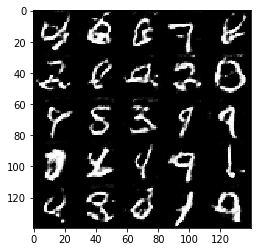

Epoch 2/2... Discriminator Loss: 1.1387... Generator Loss: 2.3912
Epoch 2/2... Discriminator Loss: 1.1287... Generator Loss: 0.7842
Epoch 2/2... Discriminator Loss: 1.0247... Generator Loss: 1.9585
Epoch 2/2... Discriminator Loss: 0.9418... Generator Loss: 1.0972
Epoch 2/2... Discriminator Loss: 0.8407... Generator Loss: 1.2381
Epoch 2/2... Discriminator Loss: 0.8819... Generator Loss: 1.0197
Epoch 2/2... Discriminator Loss: 1.0199... Generator Loss: 0.8055
Epoch 2/2... Discriminator Loss: 0.9692... Generator Loss: 1.6409
Epoch 2/2... Discriminator Loss: 1.2472... Generator Loss: 0.7956
Epoch 2/2... Discriminator Loss: 0.9436... Generator Loss: 0.9713


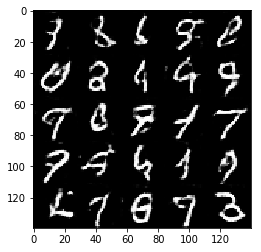

Epoch 2/2... Discriminator Loss: 0.9250... Generator Loss: 1.0925
Epoch 2/2... Discriminator Loss: 0.9684... Generator Loss: 0.9028
Epoch 2/2... Discriminator Loss: 0.9477... Generator Loss: 0.9569
Epoch 2/2... Discriminator Loss: 1.2281... Generator Loss: 0.6713
Epoch 2/2... Discriminator Loss: 0.8281... Generator Loss: 1.1973
Epoch 2/2... Discriminator Loss: 1.0442... Generator Loss: 0.7927
Epoch 2/2... Discriminator Loss: 0.9155... Generator Loss: 1.0041
Epoch 2/2... Discriminator Loss: 0.8651... Generator Loss: 1.6100
Epoch 2/2... Discriminator Loss: 1.1178... Generator Loss: 0.7747
Epoch 2/2... Discriminator Loss: 1.6798... Generator Loss: 3.0678


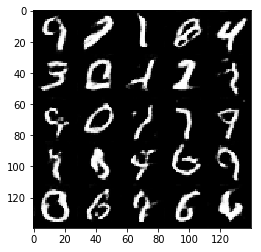

Epoch 2/2... Discriminator Loss: 0.8941... Generator Loss: 1.0698
Epoch 2/2... Discriminator Loss: 1.0571... Generator Loss: 0.8698
Epoch 2/2... Discriminator Loss: 0.8889... Generator Loss: 1.0698
Epoch 2/2... Discriminator Loss: 1.2752... Generator Loss: 2.7747
Epoch 2/2... Discriminator Loss: 1.1641... Generator Loss: 0.7411
Epoch 2/2... Discriminator Loss: 0.8820... Generator Loss: 1.0839
Epoch 2/2... Discriminator Loss: 0.8707... Generator Loss: 1.0716
Epoch 2/2... Discriminator Loss: 0.8608... Generator Loss: 1.2287
Epoch 2/2... Discriminator Loss: 0.9702... Generator Loss: 1.0217
Epoch 2/2... Discriminator Loss: 1.1194... Generator Loss: 0.8550


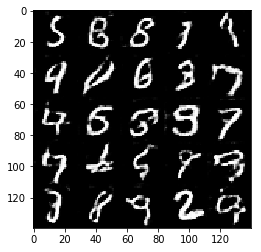

Epoch 2/2... Discriminator Loss: 1.1537... Generator Loss: 0.7651
Epoch 2/2... Discriminator Loss: 1.0387... Generator Loss: 1.4510
Epoch 2/2... Discriminator Loss: 0.8105... Generator Loss: 1.4478
Epoch 2/2... Discriminator Loss: 0.8504... Generator Loss: 1.3711
Epoch 2/2... Discriminator Loss: 0.8881... Generator Loss: 1.4892
Epoch 2/2... Discriminator Loss: 1.0879... Generator Loss: 0.7779
Epoch 2/2... Discriminator Loss: 0.8741... Generator Loss: 1.2485
Epoch 2/2... Discriminator Loss: 0.9110... Generator Loss: 1.7616
Epoch 2/2... Discriminator Loss: 0.8936... Generator Loss: 1.5694
Epoch 2/2... Discriminator Loss: 0.8861... Generator Loss: 1.0268


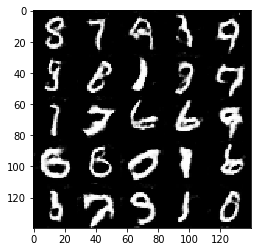

Epoch 2/2... Discriminator Loss: 0.9276... Generator Loss: 0.9687
Epoch 2/2... Discriminator Loss: 0.9666... Generator Loss: 1.0320
Epoch 2/2... Discriminator Loss: 0.9749... Generator Loss: 0.8926
Epoch 2/2... Discriminator Loss: 0.7613... Generator Loss: 1.6372
Epoch 2/2... Discriminator Loss: 1.5822... Generator Loss: 0.4344
Epoch 2/2... Discriminator Loss: 1.1882... Generator Loss: 0.8438
Epoch 2/2... Discriminator Loss: 0.9924... Generator Loss: 1.1633


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

Epoch 1/1... Discriminator Loss: 0.6635... Generator Loss: 2.6208
Epoch 1/1... Discriminator Loss: 0.5171... Generator Loss: 5.9576
Epoch 1/1... Discriminator Loss: 0.9434... Generator Loss: 4.5532
Epoch 1/1... Discriminator Loss: 0.9883... Generator Loss: 1.3031
Epoch 1/1... Discriminator Loss: 0.4266... Generator Loss: 3.6278
Epoch 1/1... Discriminator Loss: 0.6535... Generator Loss: 1.7355
Epoch 1/1... Discriminator Loss: 0.6394... Generator Loss: 3.2757
Epoch 1/1... Discriminator Loss: 0.5272... Generator Loss: 2.5773
Epoch 1/1... Discriminator Loss: 0.4938... Generator Loss: 2.2639
Epoch 1/1... Discriminator Loss: 0.6107... Generator Loss: 2.0199


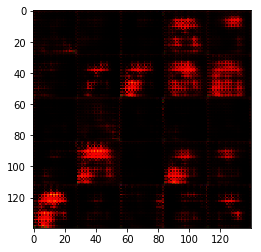

Epoch 1/1... Discriminator Loss: 0.4906... Generator Loss: 4.7177
Epoch 1/1... Discriminator Loss: 6.6824... Generator Loss: 12.1958
Epoch 1/1... Discriminator Loss: 1.2869... Generator Loss: 1.1015
Epoch 1/1... Discriminator Loss: 0.8712... Generator Loss: 1.2599
Epoch 1/1... Discriminator Loss: 0.9868... Generator Loss: 2.0520
Epoch 1/1... Discriminator Loss: 1.0734... Generator Loss: 1.9953
Epoch 1/1... Discriminator Loss: 1.7425... Generator Loss: 0.3826
Epoch 1/1... Discriminator Loss: 1.1829... Generator Loss: 1.2268
Epoch 1/1... Discriminator Loss: 1.4086... Generator Loss: 0.8518
Epoch 1/1... Discriminator Loss: 1.2163... Generator Loss: 0.7233


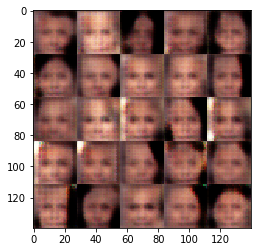

Epoch 1/1... Discriminator Loss: 1.2762... Generator Loss: 0.8202
Epoch 1/1... Discriminator Loss: 1.0826... Generator Loss: 1.4488
Epoch 1/1... Discriminator Loss: 1.5480... Generator Loss: 1.4554
Epoch 1/1... Discriminator Loss: 1.1184... Generator Loss: 0.7442
Epoch 1/1... Discriminator Loss: 1.3038... Generator Loss: 0.8651
Epoch 1/1... Discriminator Loss: 1.2226... Generator Loss: 1.0445
Epoch 1/1... Discriminator Loss: 1.2978... Generator Loss: 0.7549
Epoch 1/1... Discriminator Loss: 1.2956... Generator Loss: 0.8022
Epoch 1/1... Discriminator Loss: 1.3636... Generator Loss: 0.6897
Epoch 1/1... Discriminator Loss: 1.0502... Generator Loss: 1.4712


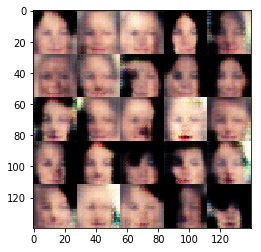

Epoch 1/1... Discriminator Loss: 0.9124... Generator Loss: 1.4509
Epoch 1/1... Discriminator Loss: 1.0586... Generator Loss: 0.9160
Epoch 1/1... Discriminator Loss: 1.4511... Generator Loss: 0.4657
Epoch 1/1... Discriminator Loss: 1.2195... Generator Loss: 1.5226
Epoch 1/1... Discriminator Loss: 1.1125... Generator Loss: 1.1325
Epoch 1/1... Discriminator Loss: 1.2902... Generator Loss: 0.7191
Epoch 1/1... Discriminator Loss: 1.1498... Generator Loss: 0.8416
Epoch 1/1... Discriminator Loss: 1.2848... Generator Loss: 0.7776
Epoch 1/1... Discriminator Loss: 1.9145... Generator Loss: 0.2802
Epoch 1/1... Discriminator Loss: 1.1082... Generator Loss: 1.2230


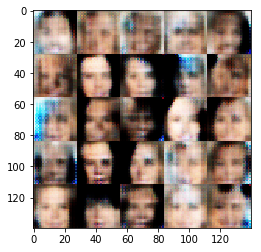

Epoch 1/1... Discriminator Loss: 1.4833... Generator Loss: 2.0466
Epoch 1/1... Discriminator Loss: 0.8034... Generator Loss: 1.5415
Epoch 1/1... Discriminator Loss: 1.1546... Generator Loss: 0.6480
Epoch 1/1... Discriminator Loss: 1.1812... Generator Loss: 0.8394
Epoch 1/1... Discriminator Loss: 0.9518... Generator Loss: 1.0477
Epoch 1/1... Discriminator Loss: 1.2184... Generator Loss: 0.9924
Epoch 1/1... Discriminator Loss: 1.2908... Generator Loss: 0.8527
Epoch 1/1... Discriminator Loss: 1.2357... Generator Loss: 0.9712
Epoch 1/1... Discriminator Loss: 1.3955... Generator Loss: 0.6073
Epoch 1/1... Discriminator Loss: 1.0635... Generator Loss: 1.1717


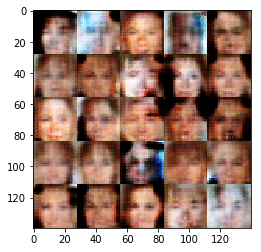

Epoch 1/1... Discriminator Loss: 1.5523... Generator Loss: 0.5931
Epoch 1/1... Discriminator Loss: 1.5956... Generator Loss: 0.4272
Epoch 1/1... Discriminator Loss: 1.2407... Generator Loss: 0.6906
Epoch 1/1... Discriminator Loss: 1.5402... Generator Loss: 0.6955
Epoch 1/1... Discriminator Loss: 1.0282... Generator Loss: 1.7090
Epoch 1/1... Discriminator Loss: 2.0579... Generator Loss: 0.2622
Epoch 1/1... Discriminator Loss: 1.1844... Generator Loss: 1.0045
Epoch 1/1... Discriminator Loss: 1.5009... Generator Loss: 0.7875
Epoch 1/1... Discriminator Loss: 1.2890... Generator Loss: 0.6643
Epoch 1/1... Discriminator Loss: 1.2547... Generator Loss: 1.2426


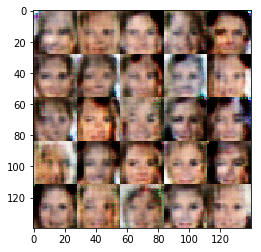

Epoch 1/1... Discriminator Loss: 1.3409... Generator Loss: 0.6901
Epoch 1/1... Discriminator Loss: 1.3804... Generator Loss: 0.5383
Epoch 1/1... Discriminator Loss: 1.4042... Generator Loss: 0.7307
Epoch 1/1... Discriminator Loss: 1.5044... Generator Loss: 1.7383
Epoch 1/1... Discriminator Loss: 1.4054... Generator Loss: 0.5633
Epoch 1/1... Discriminator Loss: 0.8011... Generator Loss: 2.2206
Epoch 1/1... Discriminator Loss: 1.2483... Generator Loss: 0.5992
Epoch 1/1... Discriminator Loss: 1.3313... Generator Loss: 0.5899
Epoch 1/1... Discriminator Loss: 1.2300... Generator Loss: 0.9554
Epoch 1/1... Discriminator Loss: 1.3818... Generator Loss: 1.0496


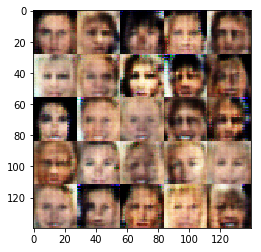

Epoch 1/1... Discriminator Loss: 1.3802... Generator Loss: 0.7881
Epoch 1/1... Discriminator Loss: 1.3059... Generator Loss: 1.2800
Epoch 1/1... Discriminator Loss: 1.2707... Generator Loss: 0.8262
Epoch 1/1... Discriminator Loss: 1.3435... Generator Loss: 0.7216
Epoch 1/1... Discriminator Loss: 1.1423... Generator Loss: 1.5386
Epoch 1/1... Discriminator Loss: 1.3705... Generator Loss: 1.4615
Epoch 1/1... Discriminator Loss: 1.3879... Generator Loss: 0.5866
Epoch 1/1... Discriminator Loss: 1.2942... Generator Loss: 1.0528
Epoch 1/1... Discriminator Loss: 1.2455... Generator Loss: 0.7173
Epoch 1/1... Discriminator Loss: 1.4368... Generator Loss: 0.5770


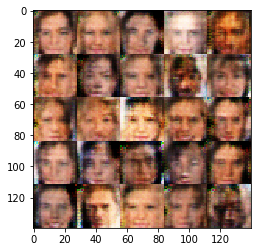

Epoch 1/1... Discriminator Loss: 1.3614... Generator Loss: 1.5139
Epoch 1/1... Discriminator Loss: 1.3375... Generator Loss: 1.1554
Epoch 1/1... Discriminator Loss: 1.5048... Generator Loss: 0.8155
Epoch 1/1... Discriminator Loss: 1.3531... Generator Loss: 0.7889
Epoch 1/1... Discriminator Loss: 1.2752... Generator Loss: 0.8632
Epoch 1/1... Discriminator Loss: 1.3345... Generator Loss: 0.6996
Epoch 1/1... Discriminator Loss: 1.5458... Generator Loss: 1.1624
Epoch 1/1... Discriminator Loss: 1.8949... Generator Loss: 2.2906
Epoch 1/1... Discriminator Loss: 1.5799... Generator Loss: 0.3830
Epoch 1/1... Discriminator Loss: 1.3848... Generator Loss: 0.7840


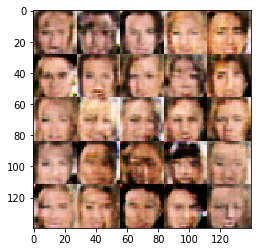

Epoch 1/1... Discriminator Loss: 1.1885... Generator Loss: 0.7337
Epoch 1/1... Discriminator Loss: 1.4297... Generator Loss: 0.9953
Epoch 1/1... Discriminator Loss: 1.1458... Generator Loss: 0.9505
Epoch 1/1... Discriminator Loss: 1.3446... Generator Loss: 0.7885
Epoch 1/1... Discriminator Loss: 1.2624... Generator Loss: 0.8597
Epoch 1/1... Discriminator Loss: 1.4662... Generator Loss: 0.5536
Epoch 1/1... Discriminator Loss: 1.1388... Generator Loss: 0.7493
Epoch 1/1... Discriminator Loss: 1.4432... Generator Loss: 0.4454
Epoch 1/1... Discriminator Loss: 1.4186... Generator Loss: 1.0688
Epoch 1/1... Discriminator Loss: 1.4904... Generator Loss: 0.4468


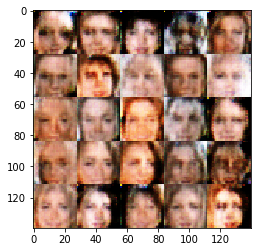

Epoch 1/1... Discriminator Loss: 1.3577... Generator Loss: 0.9579
Epoch 1/1... Discriminator Loss: 1.4756... Generator Loss: 0.6143
Epoch 1/1... Discriminator Loss: 1.2961... Generator Loss: 0.8042
Epoch 1/1... Discriminator Loss: 0.9653... Generator Loss: 1.3168
Epoch 1/1... Discriminator Loss: 1.4968... Generator Loss: 0.7849
Epoch 1/1... Discriminator Loss: 1.3341... Generator Loss: 0.8891
Epoch 1/1... Discriminator Loss: 1.3685... Generator Loss: 0.7253
Epoch 1/1... Discriminator Loss: 1.3404... Generator Loss: 0.9025
Epoch 1/1... Discriminator Loss: 1.2645... Generator Loss: 0.8479
Epoch 1/1... Discriminator Loss: 1.6065... Generator Loss: 0.4065


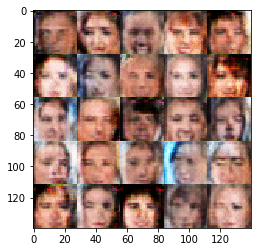

Epoch 1/1... Discriminator Loss: 1.6008... Generator Loss: 0.3544
Epoch 1/1... Discriminator Loss: 1.2181... Generator Loss: 1.1289
Epoch 1/1... Discriminator Loss: 1.2560... Generator Loss: 0.9682
Epoch 1/1... Discriminator Loss: 1.3160... Generator Loss: 1.1959
Epoch 1/1... Discriminator Loss: 1.2201... Generator Loss: 0.7981
Epoch 1/1... Discriminator Loss: 1.2491... Generator Loss: 1.1460
Epoch 1/1... Discriminator Loss: 1.2200... Generator Loss: 0.7130
Epoch 1/1... Discriminator Loss: 1.4682... Generator Loss: 0.8232
Epoch 1/1... Discriminator Loss: 1.4792... Generator Loss: 0.9793
Epoch 1/1... Discriminator Loss: 1.3934... Generator Loss: 0.6182


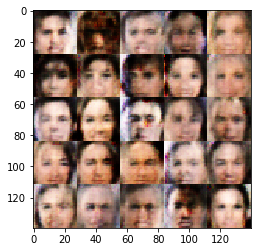

Epoch 1/1... Discriminator Loss: 1.2531... Generator Loss: 0.8170
Epoch 1/1... Discriminator Loss: 1.4623... Generator Loss: 1.2401
Epoch 1/1... Discriminator Loss: 1.2366... Generator Loss: 0.9501
Epoch 1/1... Discriminator Loss: 1.3075... Generator Loss: 1.3609
Epoch 1/1... Discriminator Loss: 1.4270... Generator Loss: 0.9645
Epoch 1/1... Discriminator Loss: 1.4111... Generator Loss: 0.8603
Epoch 1/1... Discriminator Loss: 1.2284... Generator Loss: 0.7865
Epoch 1/1... Discriminator Loss: 1.4061... Generator Loss: 0.6807
Epoch 1/1... Discriminator Loss: 1.2659... Generator Loss: 1.0759
Epoch 1/1... Discriminator Loss: 1.4578... Generator Loss: 0.7154


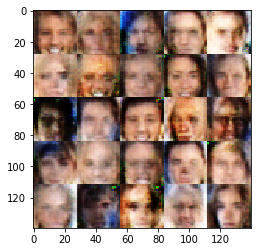

Epoch 1/1... Discriminator Loss: 1.3840... Generator Loss: 0.7229
Epoch 1/1... Discriminator Loss: 1.3608... Generator Loss: 0.7311
Epoch 1/1... Discriminator Loss: 1.4321... Generator Loss: 0.7518
Epoch 1/1... Discriminator Loss: 1.2556... Generator Loss: 0.9692
Epoch 1/1... Discriminator Loss: 1.2830... Generator Loss: 0.7561
Epoch 1/1... Discriminator Loss: 1.3029... Generator Loss: 0.9397
Epoch 1/1... Discriminator Loss: 1.5198... Generator Loss: 0.4745
Epoch 1/1... Discriminator Loss: 1.2650... Generator Loss: 1.0075
Epoch 1/1... Discriminator Loss: 1.3682... Generator Loss: 0.6288
Epoch 1/1... Discriminator Loss: 1.3223... Generator Loss: 0.6662


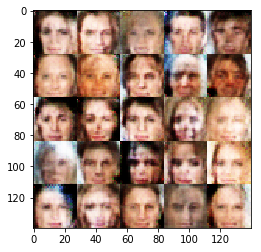

Epoch 1/1... Discriminator Loss: 1.3569... Generator Loss: 0.8252
Epoch 1/1... Discriminator Loss: 1.3871... Generator Loss: 0.7830
Epoch 1/1... Discriminator Loss: 1.8022... Generator Loss: 0.2896
Epoch 1/1... Discriminator Loss: 1.3923... Generator Loss: 0.6645
Epoch 1/1... Discriminator Loss: 1.4469... Generator Loss: 1.4170
Epoch 1/1... Discriminator Loss: 1.3721... Generator Loss: 0.7974
Epoch 1/1... Discriminator Loss: 1.1933... Generator Loss: 1.0238
Epoch 1/1... Discriminator Loss: 1.2738... Generator Loss: 0.9327
Epoch 1/1... Discriminator Loss: 1.4144... Generator Loss: 0.9993
Epoch 1/1... Discriminator Loss: 1.3502... Generator Loss: 0.6667


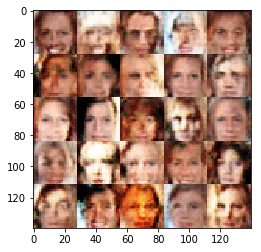

Epoch 1/1... Discriminator Loss: 1.4132... Generator Loss: 0.5582
Epoch 1/1... Discriminator Loss: 1.3437... Generator Loss: 0.7727
Epoch 1/1... Discriminator Loss: 1.3675... Generator Loss: 0.7321
Epoch 1/1... Discriminator Loss: 1.3730... Generator Loss: 0.9555
Epoch 1/1... Discriminator Loss: 1.4001... Generator Loss: 0.6890
Epoch 1/1... Discriminator Loss: 1.4468... Generator Loss: 0.4802
Epoch 1/1... Discriminator Loss: 1.4452... Generator Loss: 0.6017
Epoch 1/1... Discriminator Loss: 1.2895... Generator Loss: 0.9879
Epoch 1/1... Discriminator Loss: 1.3213... Generator Loss: 0.7545
Epoch 1/1... Discriminator Loss: 1.4087... Generator Loss: 0.7632


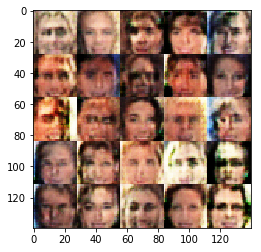

Epoch 1/1... Discriminator Loss: 1.4724... Generator Loss: 0.4925
Epoch 1/1... Discriminator Loss: 1.3801... Generator Loss: 0.7973
Epoch 1/1... Discriminator Loss: 1.5132... Generator Loss: 0.9511
Epoch 1/1... Discriminator Loss: 1.3006... Generator Loss: 0.9248
Epoch 1/1... Discriminator Loss: 1.4002... Generator Loss: 0.7541
Epoch 1/1... Discriminator Loss: 1.3821... Generator Loss: 0.6088
Epoch 1/1... Discriminator Loss: 1.6036... Generator Loss: 1.3762
Epoch 1/1... Discriminator Loss: 1.2994... Generator Loss: 1.0744
Epoch 1/1... Discriminator Loss: 1.4678... Generator Loss: 0.6439
Epoch 1/1... Discriminator Loss: 1.5260... Generator Loss: 0.4740


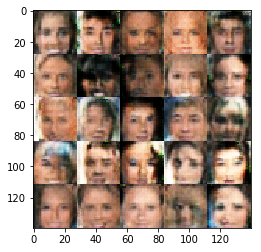

Epoch 1/1... Discriminator Loss: 1.3717... Generator Loss: 0.6639
Epoch 1/1... Discriminator Loss: 1.3463... Generator Loss: 0.7220
Epoch 1/1... Discriminator Loss: 1.3487... Generator Loss: 0.9054
Epoch 1/1... Discriminator Loss: 1.3769... Generator Loss: 0.7837
Epoch 1/1... Discriminator Loss: 1.5438... Generator Loss: 0.5937
Epoch 1/1... Discriminator Loss: 1.1925... Generator Loss: 0.8585
Epoch 1/1... Discriminator Loss: 1.5108... Generator Loss: 0.8107
Epoch 1/1... Discriminator Loss: 1.3479... Generator Loss: 0.8114
Epoch 1/1... Discriminator Loss: 1.2299... Generator Loss: 0.8803
Epoch 1/1... Discriminator Loss: 1.2651... Generator Loss: 0.7570


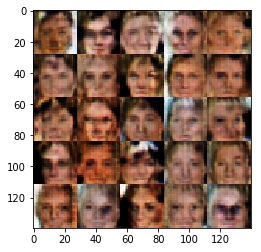

Epoch 1/1... Discriminator Loss: 1.4447... Generator Loss: 0.6179
Epoch 1/1... Discriminator Loss: 1.3410... Generator Loss: 0.9721
Epoch 1/1... Discriminator Loss: 1.2921... Generator Loss: 1.2052
Epoch 1/1... Discriminator Loss: 1.3283... Generator Loss: 0.9427
Epoch 1/1... Discriminator Loss: 1.3041... Generator Loss: 0.7806
Epoch 1/1... Discriminator Loss: 1.4502... Generator Loss: 0.6852
Epoch 1/1... Discriminator Loss: 1.3364... Generator Loss: 1.0475
Epoch 1/1... Discriminator Loss: 1.3068... Generator Loss: 0.9476
Epoch 1/1... Discriminator Loss: 1.2938... Generator Loss: 0.9685
Epoch 1/1... Discriminator Loss: 1.4735... Generator Loss: 0.5542


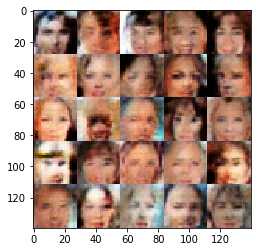

Epoch 1/1... Discriminator Loss: 1.3093... Generator Loss: 0.8099
Epoch 1/1... Discriminator Loss: 1.3734... Generator Loss: 0.6992
Epoch 1/1... Discriminator Loss: 1.4837... Generator Loss: 0.5886
Epoch 1/1... Discriminator Loss: 1.3110... Generator Loss: 0.9667
Epoch 1/1... Discriminator Loss: 1.4147... Generator Loss: 0.9200
Epoch 1/1... Discriminator Loss: 1.3674... Generator Loss: 0.6883
Epoch 1/1... Discriminator Loss: 1.2852... Generator Loss: 1.0330
Epoch 1/1... Discriminator Loss: 1.2894... Generator Loss: 0.9344
Epoch 1/1... Discriminator Loss: 1.1895... Generator Loss: 0.8798
Epoch 1/1... Discriminator Loss: 1.4130... Generator Loss: 0.7914


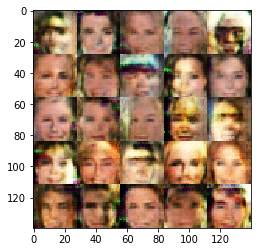

Epoch 1/1... Discriminator Loss: 1.3060... Generator Loss: 0.7511
Epoch 1/1... Discriminator Loss: 1.4302... Generator Loss: 0.6394
Epoch 1/1... Discriminator Loss: 1.3354... Generator Loss: 0.7412
Epoch 1/1... Discriminator Loss: 1.5316... Generator Loss: 0.4699
Epoch 1/1... Discriminator Loss: 1.3360... Generator Loss: 0.7564
Epoch 1/1... Discriminator Loss: 1.3748... Generator Loss: 0.9328
Epoch 1/1... Discriminator Loss: 1.3011... Generator Loss: 0.7149
Epoch 1/1... Discriminator Loss: 1.3411... Generator Loss: 0.7330
Epoch 1/1... Discriminator Loss: 1.3431... Generator Loss: 0.7667
Epoch 1/1... Discriminator Loss: 1.5367... Generator Loss: 0.6442


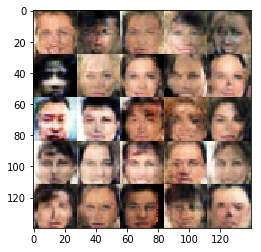

Epoch 1/1... Discriminator Loss: 1.3587... Generator Loss: 0.7105
Epoch 1/1... Discriminator Loss: 1.4629... Generator Loss: 0.6467
Epoch 1/1... Discriminator Loss: 1.5333... Generator Loss: 0.8289
Epoch 1/1... Discriminator Loss: 1.4835... Generator Loss: 0.4824
Epoch 1/1... Discriminator Loss: 1.3330... Generator Loss: 0.9264
Epoch 1/1... Discriminator Loss: 1.4501... Generator Loss: 0.7557
Epoch 1/1... Discriminator Loss: 1.3579... Generator Loss: 0.8731
Epoch 1/1... Discriminator Loss: 1.4515... Generator Loss: 0.9340
Epoch 1/1... Discriminator Loss: 1.3060... Generator Loss: 0.8987
Epoch 1/1... Discriminator Loss: 1.3188... Generator Loss: 0.6393


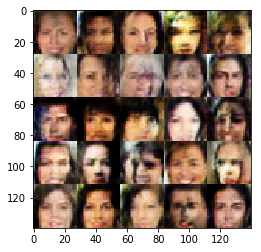

Epoch 1/1... Discriminator Loss: 1.4152... Generator Loss: 0.6163
Epoch 1/1... Discriminator Loss: 1.4929... Generator Loss: 0.6064
Epoch 1/1... Discriminator Loss: 1.5524... Generator Loss: 0.4964
Epoch 1/1... Discriminator Loss: 1.4786... Generator Loss: 0.7433
Epoch 1/1... Discriminator Loss: 1.4437... Generator Loss: 0.6628
Epoch 1/1... Discriminator Loss: 1.4178... Generator Loss: 0.7201
Epoch 1/1... Discriminator Loss: 1.2742... Generator Loss: 0.8131
Epoch 1/1... Discriminator Loss: 1.3555... Generator Loss: 0.7472
Epoch 1/1... Discriminator Loss: 1.2990... Generator Loss: 0.8521
Epoch 1/1... Discriminator Loss: 0.8481... Generator Loss: 1.3975


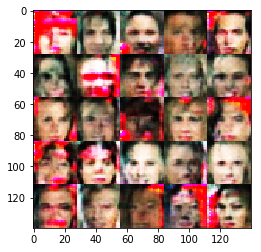

Epoch 1/1... Discriminator Loss: 1.3439... Generator Loss: 0.6907
Epoch 1/1... Discriminator Loss: 1.3787... Generator Loss: 0.7232
Epoch 1/1... Discriminator Loss: 1.3393... Generator Loss: 1.2362
Epoch 1/1... Discriminator Loss: 1.4625... Generator Loss: 0.6389
Epoch 1/1... Discriminator Loss: 1.2682... Generator Loss: 0.9903
Epoch 1/1... Discriminator Loss: 1.3393... Generator Loss: 0.6646
Epoch 1/1... Discriminator Loss: 1.5688... Generator Loss: 0.5454
Epoch 1/1... Discriminator Loss: 1.1573... Generator Loss: 1.0297
Epoch 1/1... Discriminator Loss: 1.1199... Generator Loss: 1.0091
Epoch 1/1... Discriminator Loss: 1.0635... Generator Loss: 1.0411


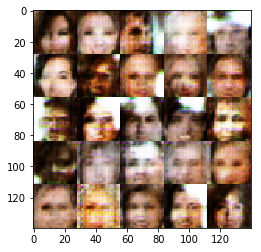

Epoch 1/1... Discriminator Loss: 1.9337... Generator Loss: 0.2622
Epoch 1/1... Discriminator Loss: 1.2560... Generator Loss: 0.8398
Epoch 1/1... Discriminator Loss: 1.2232... Generator Loss: 0.7815
Epoch 1/1... Discriminator Loss: 1.4801... Generator Loss: 0.6008
Epoch 1/1... Discriminator Loss: 1.3070... Generator Loss: 0.6860
Epoch 1/1... Discriminator Loss: 1.3470... Generator Loss: 0.7634
Epoch 1/1... Discriminator Loss: 1.5236... Generator Loss: 0.6591
Epoch 1/1... Discriminator Loss: 1.3827... Generator Loss: 0.9191
Epoch 1/1... Discriminator Loss: 1.2797... Generator Loss: 0.8605
Epoch 1/1... Discriminator Loss: 1.3069... Generator Loss: 1.0828


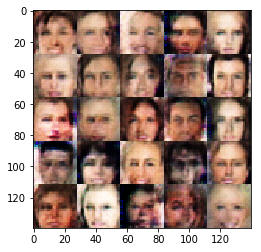

Epoch 1/1... Discriminator Loss: 1.4493... Generator Loss: 0.9787
Epoch 1/1... Discriminator Loss: 1.3226... Generator Loss: 0.8376
Epoch 1/1... Discriminator Loss: 1.3657... Generator Loss: 0.7043
Epoch 1/1... Discriminator Loss: 2.0819... Generator Loss: 0.2141
Epoch 1/1... Discriminator Loss: 1.4158... Generator Loss: 0.5562
Epoch 1/1... Discriminator Loss: 1.2893... Generator Loss: 0.7726
Epoch 1/1... Discriminator Loss: 1.3175... Generator Loss: 0.7764
Epoch 1/1... Discriminator Loss: 1.3040... Generator Loss: 0.9346
Epoch 1/1... Discriminator Loss: 1.5212... Generator Loss: 0.6124
Epoch 1/1... Discriminator Loss: 1.3328... Generator Loss: 1.0946


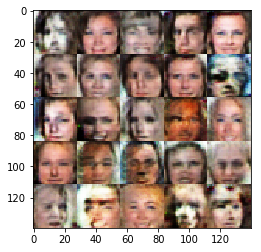

Epoch 1/1... Discriminator Loss: 1.3074... Generator Loss: 0.8244
Epoch 1/1... Discriminator Loss: 1.5227... Generator Loss: 0.6513
Epoch 1/1... Discriminator Loss: 1.3824... Generator Loss: 0.5856
Epoch 1/1... Discriminator Loss: 1.5399... Generator Loss: 0.5881
Epoch 1/1... Discriminator Loss: 1.3308... Generator Loss: 0.8962
Epoch 1/1... Discriminator Loss: 1.4280... Generator Loss: 0.7422
Epoch 1/1... Discriminator Loss: 1.2792... Generator Loss: 0.9444
Epoch 1/1... Discriminator Loss: 1.3914... Generator Loss: 0.9070
Epoch 1/1... Discriminator Loss: 1.3808... Generator Loss: 0.7781
Epoch 1/1... Discriminator Loss: 1.4229... Generator Loss: 0.7619


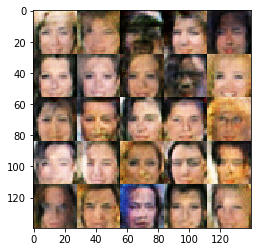

Epoch 1/1... Discriminator Loss: 1.3483... Generator Loss: 1.0495
Epoch 1/1... Discriminator Loss: 1.3219... Generator Loss: 0.8450
Epoch 1/1... Discriminator Loss: 1.3759... Generator Loss: 0.8250
Epoch 1/1... Discriminator Loss: 1.4419... Generator Loss: 0.6523
Epoch 1/1... Discriminator Loss: 1.2803... Generator Loss: 0.8917
Epoch 1/1... Discriminator Loss: 1.3013... Generator Loss: 0.7574
Epoch 1/1... Discriminator Loss: 1.3968... Generator Loss: 0.7108
Epoch 1/1... Discriminator Loss: 1.3129... Generator Loss: 0.9058
Epoch 1/1... Discriminator Loss: 1.4153... Generator Loss: 0.8783
Epoch 1/1... Discriminator Loss: 1.3831... Generator Loss: 0.7992


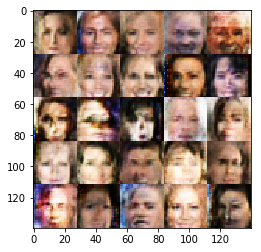

Epoch 1/1... Discriminator Loss: 1.4230... Generator Loss: 0.5748
Epoch 1/1... Discriminator Loss: 1.3313... Generator Loss: 0.9232
Epoch 1/1... Discriminator Loss: 1.2939... Generator Loss: 0.8525
Epoch 1/1... Discriminator Loss: 1.3392... Generator Loss: 1.0006
Epoch 1/1... Discriminator Loss: 1.4827... Generator Loss: 0.5120
Epoch 1/1... Discriminator Loss: 1.2983... Generator Loss: 0.8530
Epoch 1/1... Discriminator Loss: 1.4825... Generator Loss: 0.6011
Epoch 1/1... Discriminator Loss: 1.3184... Generator Loss: 0.8947
Epoch 1/1... Discriminator Loss: 1.2802... Generator Loss: 0.8693
Epoch 1/1... Discriminator Loss: 1.4412... Generator Loss: 0.7739


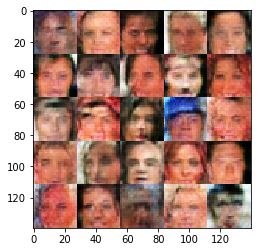

Epoch 1/1... Discriminator Loss: 1.3356... Generator Loss: 0.7553
Epoch 1/1... Discriminator Loss: 1.4345... Generator Loss: 0.7667
Epoch 1/1... Discriminator Loss: 1.3151... Generator Loss: 0.8760
Epoch 1/1... Discriminator Loss: 1.4366... Generator Loss: 0.7039
Epoch 1/1... Discriminator Loss: 1.3346... Generator Loss: 0.9874
Epoch 1/1... Discriminator Loss: 1.3435... Generator Loss: 0.7690
Epoch 1/1... Discriminator Loss: 1.3227... Generator Loss: 0.7796
Epoch 1/1... Discriminator Loss: 1.4459... Generator Loss: 0.7080
Epoch 1/1... Discriminator Loss: 1.3379... Generator Loss: 0.6979
Epoch 1/1... Discriminator Loss: 1.6802... Generator Loss: 0.5041


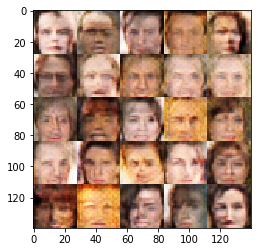

Epoch 1/1... Discriminator Loss: 1.2873... Generator Loss: 0.8386
Epoch 1/1... Discriminator Loss: 1.3842... Generator Loss: 0.7583
Epoch 1/1... Discriminator Loss: 1.4189... Generator Loss: 0.7991
Epoch 1/1... Discriminator Loss: 1.3378... Generator Loss: 0.8856
Epoch 1/1... Discriminator Loss: 1.3755... Generator Loss: 0.8002
Epoch 1/1... Discriminator Loss: 1.3075... Generator Loss: 0.8532
Epoch 1/1... Discriminator Loss: 1.3158... Generator Loss: 0.9599
Epoch 1/1... Discriminator Loss: 1.4263... Generator Loss: 0.6772
Epoch 1/1... Discriminator Loss: 1.3762... Generator Loss: 0.8854
Epoch 1/1... Discriminator Loss: 1.4065... Generator Loss: 0.7769


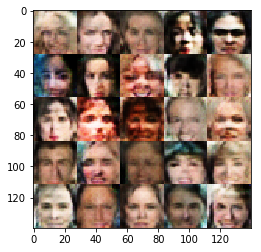

Epoch 1/1... Discriminator Loss: 1.4026... Generator Loss: 0.5969
Epoch 1/1... Discriminator Loss: 1.2856... Generator Loss: 0.8660
Epoch 1/1... Discriminator Loss: 1.3118... Generator Loss: 0.7520
Epoch 1/1... Discriminator Loss: 1.2754... Generator Loss: 0.7607
Epoch 1/1... Discriminator Loss: 1.3532... Generator Loss: 1.0381
Epoch 1/1... Discriminator Loss: 1.3217... Generator Loss: 0.8141


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。